### Preprocessing

See Dr. Graham's preprocessing method
- https://www.kaggle.com/c/diabetic-retinopathy-detection/discussion/15801

In [1]:
import cv2, glob, os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

input_path = "../input/"
train_files = glob.glob(os.path.join(input_path, "train", "*.jpeg"))

scale = 256 # target radius

## Load the original image

../input/train/10009_left.jpeg
(2592, 3888, 3)


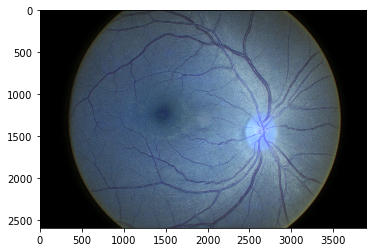

In [2]:
img_file = train_files[4]
print(img_file)
img = cv2.imread(img_file)
print(img.shape)
plt.imshow(img)

## Estimate the radius of the eye

In [3]:
def estimate_radius(img):
    mx = img[img.shape[0] // 2,:,:].sum(1)
    rx = (mx > mx.mean() / 10).sum() / 2
    
    my = img[:,img.shape[1] // 2,:].sum(1)
    ry = (my > my.mean() / 10).sum() / 2

    return (ry, rx)

ry, rx = estimate_radius(img)

(rx, ry)

(1628.0, 1296.0)

## Resize the image

Adjust the image size so that the larger side of radius will be the target radius (=256)

(408, 611, 3)


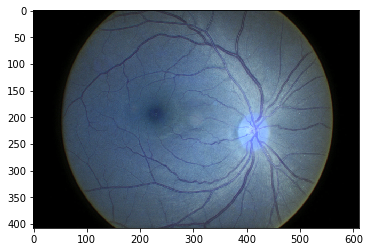

In [4]:
resize_scale = scale / max(rx, ry)
w = min(int(rx * resize_scale * 2), scale * 2)
h = min(int(ry * resize_scale * 2), scale * 2)
img_resize = cv2.resize(img.copy(), (0, 0), fx=resize_scale, fy=resize_scale)
print(img_resize.shape)
plt.imshow(img_resize)

## Crop

407 512
(407, 512, 3)


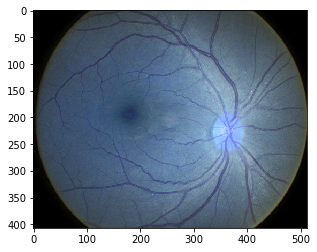

In [5]:
def crop_img(img, h, w):
    h_margin = (img.shape[0] - h) // 2 if img.shape[0] > h else 0
    w_margin = (img.shape[1] - w) // 2 if img.shape[1] > w else 0

    crop_img = img[h_margin:h + h_margin,w_margin:w + w_margin,:]

    return crop_img

print(h, w)
img_crop = crop_img(img_resize.copy(), h, w)
print(img_crop.shape)
plt.imshow(img_crop)

## Subtract local mean color

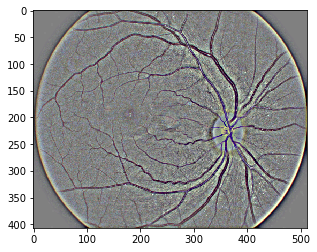

In [6]:
def subtract_gaussian_blur(img):
    # http://docs.opencv.org/trunk/d0/d86/tutorial_py_image_arithmetics.html
    # http://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html
    gb_img = cv2.GaussianBlur(img, (0, 0), 5)
    
    return cv2.addWeighted(img, 4, gb_img, -4, 128)
        
img_gbs = subtract_gaussian_blur(img_crop.copy())
plt.imshow(img_gbs)

## Remove 10% of the outer circle

Remove the boundary effect of Gaussian blur

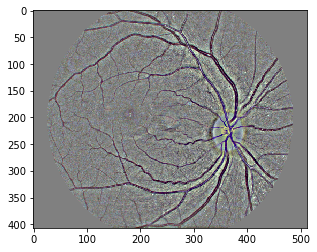

In [7]:
def remove_outer_circle(a, p, r):
    b = np.zeros(a.shape, dtype=np.uint8)
    cv2.circle(b, (a.shape[1] // 2, a.shape[0] // 2), int(r * p), (1, 1, 1), -1, 8, 0)
    
    return a * b + 128 * (1 - b)

img_remove_outer = remove_outer_circle(img_gbs.copy(), 0.9, scale)
plt.imshow(img_remove_outer)

## Place the processed image in the center of (512px, 512px) image

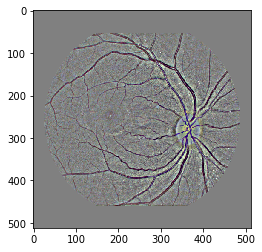

In [8]:
def place_in_square(img, r, h, w):
    new_img = np.zeros((2 * r, 2 * r, 3), dtype=np.uint8)
    new_img += 128
    new_img[r - h // 2:r - h // 2 + img.shape[0], r - w // 2:r - w // 2 + img.shape[1]] = img
    
    return new_img

new_img = place_in_square(img_remove_outer.copy(), scale, h, w)
plt.imshow(new_img)